<a href="https://www.kaggle.com/code/lucihere/fake-news-detection?scriptVersionId=231684832" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Contents
1) **Dependencies**
2) **Data Extraction**
3) **Data Wrangling**
4) **Machine Learning Models**
5) **Advanced Machine Learning Models**
6) **Results Analysis**

# 1) Dependencies
This section is for importing any relevent dependencies for this project.

In [1]:
!pip install wandb
!pip install transformers

In [2]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("wandb_api"), relogin=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Standard Library Imports
import os
import sys
import time
import json
import csv
import pickle
import datetime
import re
import string
from glob import glob

# Relevant Third-Party Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Machine Learning & NLP Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree, svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

# Deep Learning & Transformer Libraries
import torch
from transformers import BertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense

# Visualization Libraries
import seaborn as sb
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.display import display

# Weights & Biases related sub-libraries
from wandb.sklearn import (
    plot_precision_recall, 
    plot_feature_importances, 
    plot_confusion_matrix, 
    plot_class_proportions, 
    plot_learning_curve, 
    plot_roc
)

# NLP Utility libraries
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import chardet

plt.style.use("dark_background")

# 2) Data Extraction
I used Kaggle's Input directory to simplify the process of accumulating data into one single directory. <br>
I went through all the datasets individually and included them all in `/kaggle/inputs` so that I can parse through them all at once.
## 2.1) CSV file retrieval
The PHEME dataset is the only dataset that has events/data points split into seperate subdirectories, so we will deal with it later.<br>
For this section, even with a lot of subdirectories, metadata and other files to go through individually, a brief overview of the data shows the existence of many text files, CSV and TSV files in every dataset. So I'll create a script to go through all of the directories and just retrieve all them.<br>
<!-- <br> -->
<!-- 
**Following is the list of all English datasets from the list provided** (with file names in `/kaggle/inputs` for reference)**, marking the ones used:**
- [ ] [WELFake dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification) **(fake-news-classification)**
- [ ] [ISOT Fake News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets) **(fake-news-detection-datasets)**
- [ ] [FakeNewsNet created by ASU](https://www.kaggle.com/datasets/mdepak/fakenewsnet) **(fakenewsnet)**
- [ ] [The LIAR Benchmark dataset](https://www.kaggle.com/datasets/lucihere/liar-dataset) **(liar-dataset)**
- [x] [PHEME dataset for Rumour Detection and Veracity Classification](https://www.kaggle.com/datasets/usharengaraju/pheme-dataset?select=PHEME_veracity) **(pheme-data)**
- [ ] [Truth Seeker Dataset 2023](https://www.kaggle.com/datasets/paulinepeps/truth-seeker-dataset-2023-truthseeker2023) **(truth-seeker-dataset-2023-truthseeker2023)**
- [ ] ["Fake News", another unnamed dataset from Kaggle](https://www.kaggle.com/datasets/hassanamin/textdb3/data) **(textdb3)**
- [x] ["TwitterFakeNews", a GitHub repository of scraped Twitter data](https://github.com/s-helm/twitterfakenews) **(twitterfakenews)**
- [ ] ["Fake and Real News Data", an unnamed dataset from Kaggle](https://www.kaggle.com/datasets/subhajournal/fake-and-real-news-data) **(fake-and-real-news-data)**
- [ ] [Fighting an Infodemic: COVID-19 Fake News Dataset](https://arxiv.org/ftp/arxiv/papers/2011/2011.03327.pdf) **()** -->

In [ ]:
# Workflow:

# 1. **Initialize Lists and Counters**:
#    - Stores loaded file data, filenames, and paths separately for each file type.
#    - Keeps track of the number of each file type encountered.

# 2. **Iterate Through Files in the Directory**:
#    - Uses `os.walk()` to traverse through all subdirectories and files.

# 3. **Process Text Files (.txt)**:
#    - Reads the file contents into a list (`text_files`).
#    - Logs filenames and paths.
#    - Catches and logs any file read errors.

# 4. **Process CSV Files (.csv)**:
#    - Attempts to read the file using `pd.read_csv()`.
#    - If an error occurs (e.g., encoding issues), detects the file's encoding using `chardet`
#      and tries to reload the file with the correct encoding.
#    - Logs any failures.

# 5. **Process TSV Files (.tsv)**:
#    - Similar to CSV processing but with tab (`\t`) as the delimiter.
#    - Handles encoding issues using `chardet`.

# 6. **Error Handling**:
#    - If a file fails to load, its path and filename are added to `bad_pathnames` and `bad_filenames`.
#    - Errors are printed for debugging.


# Lists to store DataFrames and data files
text_files = []
csv_dataframes = []
tsv_dataframes = []

# Lists to store the corresponding paths and filenames for reference
bad_pathnames = []
txt_pathnames = []
csv_pathnames = []
tsv_pathnames = []

bad_filenames = []
txt_filenames = []
csv_filenames = []
tsv_filenames = []

count_txt = 0
count_csv = 0
count_tsv = 0

for dirname, _, filenames_in_dir in os.walk('/kaggle/input'):
    for filename in filenames_in_dir:
        # Check if the file is a txt file
        if filename.endswith('.txt'):
            file_path = os.path.join(dirname, filename)
            print(f"Found Text file {count_txt}: {file_path}")
            count_txt += 1
            try:
                with open(file_path) as f:
                    data = f.read()
                    text_files.append(data)
                    txt_pathnames.append(file_path)
                    txt_filenames.append(filename)
            except Exception as e:
                print(f"  - Error loading {file_path}: {str(e)}")
                print("-" * 80)
                bad_pathnames.append(file_path)
                bad_filenames.append(filename)
            pass
        
        # Check if the file is a CSV file
        if filename.endswith('.csv'):
            file_path = os.path.join(dirname, filename)
            print(f"Found CSV file {count_csv}: {file_path}")
            count_csv += 1
            try:
                df = pd.read_csv(file_path)
                csv_dataframes.append(df)
                csv_pathnames.append(file_path)
                csv_filenames.append(filename)

            except Exception as e:
                try: 
                    with open(file_path, 'rb') as f:
                        data = f.read()
                    encoding = chardet.detect(data)["encoding"]
                    df = pd.read_csv(file_path, sep='delimiter', encoding=encoding, header=None, on_bad_lines='warn')
                    csv_dataframes.append(df)
                    csv_pathnames.append(file_path)
                    csv_filenames.append(filename)
            
                except Exception as e:
                    print(f"  - Error loading {file_path}: {str(e)}")
                    print("-" * 80)
                    bad_pathnames.append(file_path)
                    bad_filenames.append(filename)
            pass
            
        #Check if a file is a TSV file
        if filename.endswith('.tsv'):
            file_path = os.path.join(dirname, filename)
            print(f"Found TSV file {count_tsv}: {file_path}")
            count_tsv += 1
            try:
                df = pd.read_csv(file_path, sep='\t')
                tsv_dataframes.append(df)
                tsv_pathnames.append(file_path)
                tsv_filenames.append(filename)
                
            except Exception as e:
                try: 
                    with open(file_path, 'rb') as f:
                        data = f.read()
                    encoding = chardet.detect(data)["encoding"]
                    df = pd.read_csv(file_path, sep='\t', encoding=encoding)
                    tsv_dataframes.append(df)
                    tsv_pathnames.append(file_path)
                    tsv_filenames.append(filename)
                
                except Exception as e:
                    print(f"  - Error loading {file_path}: {str(e)}")
                    print("-" * 80)
                    bad_pathnames.append(file_path)
                    bad_filenames.append(filename)
            pass

#### **Run the cell below to get a glimpse of each dataframe and which file it points to.**

In [ ]:
for i in range(len(dataframes)):
    print(f"\n{i}) {filenames[i]}")
    print(f"Filepath: {pathnames[i]}")
    print(f"Number of rows:{dataframes[i].shape}\n")

#### **NOTE 2.1.1)**
The above output currently doesnt resemble the number of inputs used.
#### **NOTE 2.1.2)**
Looking through the text files, I could find a lot of unnecessary data that wont be useful to us in any way, so Ill skip them altogether. Feel free to verify by running `print(text_files[0])` in a new cell. You can choose any of the indices apart from 0, I dont recommend printing everything, since there is a huge chunk of data and it takes a lot of time to even print.

## 2.2) PHEME Dataset Retrieval
The following code is for individually going through all the sub-directories in the PHEME Veracity Dataset.

In [51]:
# Workflow:

# 1. **Locate JSON Files**:
#    - Uses `glob()` to recursively find all `.json` files in `/kaggle/input/pheme-data/`.

# 2. **Iterate Over JSON Files**:
#    - Skips hidden binary files (those starting with ".").
#    - Determines whether the file belongs to:
#      - **Non-rumours**: If the file path contains `"non-rumours/"`, assigns label `0`.
#      - **Rumours**: If the file path contains `"rumours/"` but not `"non-rumours/"`, assigns label `1`.

# 3. **Extract Tweet Text**:
#    - Reads each JSON file and checks if it contains a `"text"` field.
#    - Appends a dictionary `{ "text": <tweet_text>, "label": <label> }` to `pheme_data`.

# 4. **Handle Missing or Irrelevant Data**:
#    - If a file doesn't belong to the "rumours" or "non-rumours" categories, assigns `pd.NA` for both text and label.

# Output:

# - `pheme_data` is a list of dictionaries formatted as follows:
#   ```python
#   [{"text": "Example tweet content", "label": 0},  # Non-rumour
#    {"text": "Another tweet", "label": 1},          # Rumour
#    {"text": pd.NA, "label": pd.NA}]                # Unrecognized format


jsons = glob("/kaggle/input/pheme-data/**/*.json", recursive=True)
annotation_path = ""
source_tweets_path = ""
pheme_data = []
for i in jsons:
    #This skips over hidden binary files
    if i.startswith("."):
        continue

    elif "non-rumours/" in i:
        source_tweets_path = i
        if os.path.exists(source_tweets_path):
            with open(source_tweets_path, "r", encoding="utf-8") as f:
                tweet_data = json.load(f)
                if "text" in tweet_data:
                    label = 0
                    pheme_data.append({"text": tweet_data["text"], "label": label})
                else:
                    continue
                    
    elif "rumours/" in i and not "non-rumours" in i:
        source_tweets_path = i
        if os.path.exists(source_tweets_path):
            with open(source_tweets_path, "r", encoding="utf-8") as f:
                tweet_data = json.load(f)
                if "text" in tweet_data:
                    label = 1
                    pheme_data.append({"text": tweet_data["text"], "label": label})
                else:
                    continue
    else:
        label = pd.NA
        pheme_data.append({"text": pd.NA, "label": label})

In [92]:
pheme_df = pd.DataFrame(pheme_data)
pheme_df.dropna(axis=0, inplace=True)
pheme_df.rename(columns={"content":"text"}, inplace=True)
pheme_count_fake = (pheme_df["label"] == 1).sum()
pheme_count_true = (pheme_df["label"] == 0).sum()
pheme_count_na = (pheme_df["label"] == pd.NA).sum()
print(f"Number of true tweets in the PHEME Dataset: {pheme_count_true}")
print(f"Number of fake tweets in the PHEME Dataset: {pheme_count_fake}")
print(f"Number of unclassified tweets in the PHEME Dataset: {pheme_count_na}")

,text,label
0,@tariqnasheed show his face and have Mike Brow...,1
1,@tariqnasheed anonymous named the wrong guy? D...,1
2,@tariqnasheed did you see how he was deliverin...,1
3,@tariqnasheed maybe it's an alias to cover his...,1
4,@tariqnasheed What do you think the outcome is...,1
...,...,...
111234,Gurlitt Kunstmuseum Bern update: There is no ...,0
111235,On the eve of a major announcement regarding t...,0
111236,"Swiss museum, German officials to announce fat...",0
111237,#Gurlitt's overlooked heirs want control of hi...,0


In [127]:
current_df = pd.read_csv("/kaggle/input/output-for-twitterfakesnews-csv/output_for_twitterfakenews.csv")
current_df = current_df.loc[:, ['text', 'label']]
current_df.dropna(axis=0, inplace=True)
curr_df = pd.concat([current_df[current_df['label']=='0'], current_df[current_df['label']=='1']])
curr_df['label'] = curr_df['label'].astype('int64')
output_csv = pd.concat([curr_df, pheme_df], ignore_index=True)
output_csv.dropna(inplace=True)
outp = pd.read_csv("/kaggle/working/output_for_pheme_and_twitter.csv", engine='python')
outp.dropna(axis=0, inplace=True)
outp['label'] = outp['label'].astype('int64')
outp

,text,label
0,washington reuters the head of a conservative...,0
1,washington reuters transgender people will be...,0
2,washington reuters the special counsel invest...,0
3,washington reuters trump campaign adviser geo...,0
4,seattlewashington reuters president donald tr...,0
...,...,...
156146,Gurlitt Kunstmuseum Bern update: There is no ...,0
156147,On the eve of a major announcement regarding t...,0
156148,"Swiss museum, German officials to announce fat...",0
156149,#Gurlitt's overlooked heirs want control of hi...,0


## 2.3) Combining the other datasets

In [145]:
truthseek_df = dataframes[12]
truthseek_df = truthseek_df.loc[:, ['tweet','BinaryNumTarget']]
truthseek_df.rename(columns = {"tweet": "text", "BinaryNumTarget": "label"}, inplace=True)
truthseek_df['label'] = truthseek_df['label'].astype('int64')
truthseek_df.dropna(axis=0, inplace=True)
output_csv2 = pd.concat([outp, truthseek_df], ignore_index = True)
output_csv2.to_csv("output_pheme_truthseeker_twitter.csv", index=False, header=True)

,text,label
0,washington reuters the head of a conservative...,0
1,washington reuters transgender people will be...,0
2,washington reuters the special counsel invest...,0
3,washington reuters trump campaign adviser geo...,0
4,seattlewashington reuters president donald tr...,0
...,...,...
290303,Joe Biden's family owned African slaves....\n\...,0
290304,"Joe Bidens great, great grandfather was a slav...",0
290305,"@ChevyChaseToGo ""Joe Bidens great-grandfather ...",0
290306,@JoeBiden Facts are Bidens VP Kamala Harris Gr...,0


In [171]:
liar_df = dataframes[14].iloc[:,[2,1]]
liar_df.columns = ['text', 'label']
liar_df1 = dataframes[15].iloc[:,[2,1]]
liar_df1.columns = ['text', 'label']
liar_df2 = dataframes[16].iloc[:,[2,1]]
liar_df2.columns = ['text', 'label']
full_liar_df = pd.concat([liar_df, liar_df1, liar_df2], ignore_index=True)
liar_mapping = {'true': 0, 'false': 1, 'half-true': 1, 'pants-fire': 1, 'barely-true': 1, 'mostly-true': 0}
full_liar_df['label'] = full_liar_df['label'].map(liar_mapping)
main_datasets_df = pd.concat([output_csv2, full_liar_df], ignore_index = True)

In [ ]:
reverse_mapping = {1:0,0:1}
welfake_df = dataframes[8].loc[:, ['text','label']]
welfake_df['label'] = welfake_df['label'].map(reverse_mapping)
main_datasets_df = pd.concat([main_datasets_df, welfake_df], ignore_index=True)
main_datasets_df.dropna(axis=0, inplace=True)
#csv.field_size_limit(sys.maxsize)
final_dataframe = pd.read_csv("/kaggle/input/final-news-dataset/cleaned_main_datasets.csv", engine='python')

In [ ]:
isot_fake_df = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv")
isot_fake_df = isot_fake_df['text']
isot_fake_df = pd.concat([isot_fake_df, pd.DataFrame([1] * len(isot_fake_df))], axis=1, names=["text","label"], ignore_index=True)
isot_fake_df.columns = ["text", "label"]
isot_real_df = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv")
isot_real_df = isot_real_df['text']
isot_real_df = pd.concat([isot_real_df, pd.DataFrame([0] * len(isot_real_df))], axis=1, names=["text","label"], ignore_index=True)
isot_real_df.columns = ["text", "label"]
final_dataframe = pd.concat([final_dataframe, isot_real_df, isot_fake_df], ignore_index=True)
final_dataframe

In [49]:
db3_mapping = {"FAKE": 1, "TRUE": 0}
textdb3_df = pd.read_csv("/kaggle/input/textdb3/fake_or_real_news.csv")
db3_df = textdb3_df.loc[:,["text","label"]]
db3_df['label'] = db3_df['label'].map(db3_mapping)
db3_df.fillna(value=0, inplace=True)
final_dataframe = pd.concat([final_dataframe, db3_df], ignore_index = True)
textdb3_df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [64]:
fakenewsnet_df = pd.read_csv("/kaggle/input/fake-and-real-news-data/Fake_Real_News_Data.csv")
fakenewsnet_df = fakenewsnet_df.loc[:,["text","label"]]
fakenewsnet_df["label"] = fakenewsnet_df["label"].map(db3_mapping)
fakenewsnet_df.fillna(value=0, inplace=True)
final_dataframe = pd.concat([final_dataframe, fakenewsnet_df], ignore_index = True)
final_dataframe.dropna(axis=0, inplace=True)
final_dataframe

,text,label
0,washington reuters the head of a conservative...,0.0
1,washington reuters transgender people will be...,0.0
2,washington reuters the special counsel invest...,0.0
3,washington reuters trump campaign adviser geo...,0.0
4,seattlewashington reuters president donald tr...,0.0
...,...,...
432747,Obama To Limit Police Acquisition Of Some Mili...,0.0
432748,BNI Store Oct 29 2016 EU using taxpayer money ...,1.0
432749,Next Story → Judge Judy LOSES IT on Hood Rat: ...,1.0
432750,America’s Streets Will Run With Blood- Mike Ad...,1.0


In [77]:
last_fake_df_1 = pd.read_csv("/kaggle/input/fakenewsnet/BuzzFeed_fake_news_content.csv")
last_fake_df_2 = pd.read_csv("/kaggle/input/fakenewsnet/PolitiFact_fake_news_content.csv")
last_real_df_1 = pd.read_csv("/kaggle/input/fakenewsnet/BuzzFeed_real_news_content.csv")
last_real_df_2 = pd.read_csv("/kaggle/input/fakenewsnet/PolitiFact_real_news_content.csv")
last_fake_df_1 = pd.concat([last_fake_df_1["text"], pd.DataFrame([1] * len(last_fake_df_1["text"]))], axis=1, names=["text","label"], ignore_index=True)
last_fake_df_1.columns = ["text", "label"]
last_fake_df_2 = pd.concat([last_fake_df_2["text"], pd.DataFrame([1] * len(last_fake_df_2["text"]))], axis=1, names=["text","label"], ignore_index=True)
last_fake_df_2.columns = ["text", "label"]
last_real_df_1 = pd.concat([last_real_df_1["text"], pd.DataFrame([0] * len(last_real_df_1["text"]))], axis=1, names=["text","label"], ignore_index=True)
last_real_df_1.columns = ["text", "label"]
last_real_df_2 = pd.concat([last_real_df_2["text"], pd.DataFrame([0] * len(last_real_df_2["text"]))], axis=1, names=["text","label"], ignore_index=True)
last_real_df_2.columns = ["text", "label"]
final_dataframe = pd.concat([final_dataframe, last_fake_df_1, last_fake_df_2, last_real_df_1, last_real_df_2], ignore_index=True)
final_dataframe.dropna(axis=0, inplace=True)
final_dataframe

,text,label
0,washington reuters the head of a conservative...,0.0
1,washington reuters transgender people will be...,0.0
2,washington reuters the special counsel invest...,0.0
3,washington reuters trump campaign adviser geo...,0.0
4,seattlewashington reuters president donald tr...,0.0
...,...,...
433169,"KALLSTADT, Germany — Few places in Germany are...",0.0
433170,Hollywood loses yet another one of their deare...,0.0
433171,"As my 25th wedding anniversary approached, I t...",0.0
433172,Story highlights Trump was sitting in a chair ...,0.0


In [75]:
final_dataframe.to_csv("main_datasets.csv",index=False, header=True)

# 3) Data Wrangling
Now that I have queried all the data files and created one big data set. We shall wrangle the data into something easier to process.<br><br>
- [x] [FakeNewsNet created by ASU](https://www.kaggle.com/datasets/mdepak/fakenewsnet) **(fakenewsnet)**
- [x] [WELFake dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification) **(fake-news-classification)**
- [x] ["TwitterFakeNews", a GitHub repository of scraped Twitter data](https://github.com/s-helm/twitterfakenews) **(twitterfakenews)**
- [x] ["Fake News", another unnamed dataset from Kaggle](https://www.kaggle.com/datasets/hassanamin/textdb3/data) **(textdb3)**
- [x] [ISOT Fake News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets) **(fake-news-detection-datasets)**
- [x] ["Fake and Real News Data", an unnamed dataset from Kaggle](https://www.kaggle.com/datasets/subhajournal/fake-and-real-news-data) **(fake-and-real-news-data)**
- [x] [Truth Seeker Dataset 2023](https://www.kaggle.com/datasets/paulinepeps/truth-seeker-dataset-2023-truthseeker2023) **(truth-seeker-dataset-2023-truthseeker2023)**
- [x] [The LIAR Benchmark dataset](https://www.kaggle.com/datasets/lucihere/liar-dataset) **(liar-dataset)**
- [x] [PHEME dataset for Rumour Detection and Veracity Classification](https://www.kaggle.com/datasets/usharengaraju/pheme-dataset?select=PHEME_veracity) **(pheme-data)**

In [4]:
final_dataframe = pd.read_csv("/kaggle/input/cleaned-main-datasets-csv/cleaned_main_datasets.csv")
final_dataframe

,text,label
0,washington reuters the head of a conservative...,0.0
1,washington reuters transgender people will be...,0.0
2,washington reuters the special counsel invest...,0.0
3,washington reuters trump campaign adviser geo...,0.0
4,seattlewashington reuters president donald tr...,0.0
...,...,...
433358,kallstadt germany — few places in germany are ...,0.0
433359,hollywood loses yet another one of their deare...,0.0
433360,as my th wedding anniversary approached i trie...,0.0
433361,story highlights trump was sitting in a chair ...,0.0


Going through an example of the text, there seems to be a lot of unnecessary symbols in the data. We can use Regex expressions to remove them.<br>

In [44]:
def clean_text(text):
    """
    Cleans given text string by removing punctuation, numbers, special characters, 
    newlines, URLs, HTML tags, and unwanted whitespace. Converts text to lowercase.

    Args:
        text (str): Input text to be cleaned.

    Returns:
        str: Cleaned text string.

    Cleaning Steps:
        - Converts text to lowercase.
        - Removes punctuation.
        - Removes numeric digits.
        - Removes text inside square brackets.
        - Removes non-word characters.
        - Removes newline characters.
        - Removes URLs.
        - Removes HTML tags.
        - Removes words containing digits.
    """
    text = str(text)
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"\\W","", text)
    text = re.sub(r"\n", "", text)
    text = re.sub("https?:://\S+|www\.\S+","", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("\w*\d\w", "", text)
    return text



def labeler(series, label):
    """
    Assigns a label to each entry in "series" and returns a new DataFrame.

    Args:
        series (pd.Series): Input text data.
        label (str): Label to assign to all rows.

    Returns:
        pd.DataFrame: DataFrame with two columns:
            - 'text': Original text entries.
            - 'label': Assigned label.
    """
    new_column = {label: [label] * len(series)}
    new_column = pd.DataFrame(new_column)
    output = pd.concat([series, new_column], ignore_index = False)
    output.columns = ['text', 'label']
    output['label'].fillna(label)
    return output

In [5]:
final_dataframe['text'] = final_dataframe['text'].apply(clean_text)
final_dataframe.dropna(axis=0, inplace=True)
final_dataframe['label'].value_counts() # 0 is True news and 1 is Fake news

label
0.0    235919
1.0    197255
Name: count, dtype: int64

In [11]:
vectorizer = TfidfVectorizer(max_features = 500, stop_words='english', max_df=0.7)
X, Y = vectorizer.fit_transform(final_dataframe['text']).toarray(), final_dataframe['label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

In [42]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
pca = PCA()
pca.fit_transform(X_train)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
pca = PCA(n_components=n_components)
X_train_pca = sc.transform(pca.fit_transform(X_train))
X_test_pca = sc.transform(pca.transform(X_test))

In [45]:
pd.DataFrame(X_test_pca)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,-0.493215,-0.565392,-0.034570,-0.947342,-0.241337,-0.128453,-0.538670,0.094781,0.101610,0.080988,...,-0.632697,0.329607,-1.463007,1.088058,-0.040302,0.668515,0.225717,-0.638685,0.988401,0.646517
1,-1.010574,0.444370,-0.318862,0.479218,-0.043904,-0.925230,-0.621700,-0.711119,-0.012720,0.033019,...,-2.044983,-0.667227,1.200730,1.878015,-0.407637,1.145714,0.881942,-1.085140,0.391066,-0.420555
2,-0.134743,0.504453,0.783916,-1.063518,0.413487,1.750054,0.510546,1.097767,-0.642459,0.675209,...,-0.188207,-0.101232,0.694090,-1.002065,0.928036,-1.512996,-0.586697,1.698348,-0.714437,1.023495
3,1.422601,-0.399825,0.566100,1.132316,1.549008,-1.771340,-0.949101,2.851538,0.677841,0.408640,...,-1.230589,-0.013272,0.030974,0.836055,0.053328,2.324613,-0.385099,-1.828535,0.924244,1.189557
4,-0.696722,-0.295338,-0.227498,-0.392667,0.653933,0.359588,-0.377235,0.517454,0.285195,-0.130230,...,0.304134,-1.233267,-0.086728,1.012046,2.640676,-2.480611,-1.332865,1.870593,-0.345394,-0.051134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86630,-0.429096,-0.277481,0.725732,0.202011,-0.315489,1.451094,-0.688323,-1.142621,0.458127,-1.020844,...,0.796403,-0.743317,0.319420,-1.493732,2.219472,-1.297036,2.276865,-1.246302,0.366079,-0.527757
86631,-0.817292,-0.261721,-0.204513,0.123568,-0.269357,0.192089,0.426594,-0.277271,0.034489,-0.287667,...,-0.983527,-0.714751,0.773603,0.895465,-0.808030,0.188295,0.799168,0.918287,0.811557,-0.070298
86632,-0.727243,-0.046211,0.165229,-0.179612,-0.156249,-0.103515,0.241505,-0.351709,0.367346,-0.121019,...,2.364664,0.656803,-0.925314,0.481169,1.984513,1.485425,0.659539,-2.385643,-2.251148,0.434461
86633,-0.213611,0.370730,1.427112,0.221735,2.477918,-0.345014,-0.773934,-0.118163,4.165016,-0.688804,...,-0.645222,-0.620243,-2.410383,0.848074,1.211688,1.256718,0.291753,0.199492,-1.023510,1.675675


In [52]:
pd.DataFrame(X_train_lda).to_csv("x_train_lda.csv", index=False)
pd.DataFrame(X_test_lda).to_csv("x_test_lda.csv", index=False)

pd.DataFrame(y_train).to_csv("y_train.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test.csv", index=False)

# 4) Model Building
- [x] **Logistic Regression** 
- [x] **Support Vector Machine (SVM)**
- [x] **Decision Trees**
- [x] **XGBoost**
- [x] **Passive Aggressive Classifier**
- [ ] **BERT**
- [ ] **CNN-RNN Hybrid**


In [4]:
X_train = pd.read_csv("/kaggle/input/cleaned-main-datasets-csv/cleaned_split_dataset/x_train.csv")
X_test = pd.read_csv("/kaggle/input/cleaned-main-datasets-csv/cleaned_split_dataset/x_test.csv")
y_train = pd.read_csv("/kaggle/input/cleaned-main-datasets-csv/cleaned_split_dataset/y_train.csv")
y_test = pd.read_csv("/kaggle/input/cleaned-main-datasets-csv/cleaned_split_dataset/y_test.csv")

In [5]:
test_size = 0.2
labels = [0,1]
named_labels = ["Real News", "Fake News"]
input_shape = (500, 1) # for the CNN-RNN Hybrid
project_name = 'fake-news-detection-models'

In [9]:
names = ["Logistic_Regressor",
         "Support_Vector_Machine",
        "Decision_Tree",
         "XGBoost",
         "Passive_Aggressive_Classifier"]

complex_names = ["BERT",
         "CNN_RNN_hybrid"]

classifiers = [
    LogisticRegression(), 
    svm.SVC(kernel="linear", C=0.025, probability = True, random_state=42),
    tree.DecisionTreeClassifier(max_depth=5, random_state=42),
    XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.05, objective='binary:logistic'),
    PassiveAggressiveClassifier()
]

complex_classifiers = [
    BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa"),
    Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
]

In [18]:
def simple_wandb_run(model_index, names, classifiers, X_train, X_test, y_train, y_test, 
                     named_labels, project_name, training_sample=None):

"""
    Trains a machine learning model, logs results using Weights & Biases (WandB), and evaluates performance.

    This function selects a model from a list of classifiers, trains it on a given dataset (or a random subset), 
    saves the trained model, makes predictions, and logs various performance metrics and visualizations to WandB.

    Args:
        model_index (int): Index of the classifier to use from `classifiers`.
        names (list of str): List of model names corresponding to `classifiers`.
        classifiers (list of estimators): List of machine learning models (e.g., scikit-learn estimators).
        X_train (pd.DataFrame): Training feature set.
        X_test (pd.DataFrame): Testing feature set.
        y_train (pd.Series): Training labels.
        y_test (pd.Series): Testing labels.
        named_labels (list of str): List of class labels for evaluation.
        project_name (str): Name of the WandB project.
        training_sample (int, optional): Number of training samples to randomly select. If None, full training set is used.

    Returns:
        None

    Workflow:
        1. Selects the model and applies an optional training sample limit.
        
        2. Converts training and test datasets to NumPy arrays.
        
        3. Trains the model on the training data.
        
        4. Saves the trained model as a `.sav` file.
        
        5. Generates predictions on the test set.
        
        6. Logs model parameters and results to Weights & Biases.
        
        7. Generates performance plots, including:
            - Class distribution
            - Learning curve
            - Feature importance (if applicable)
            - ROC and Precision-Recall curves (if `predict_proba` is available)
            
        8. Prints a classification report and confusion matrix.
        
        9. Logs results and completes the WandB run.
    """

    run_start = datetime.datetime.now()
    start_time = time.time()
    
    model = classifiers[model_index]
    name = names[model_index]


    #with the following condition, I tried generating random samples so that we can experiment with different subsets and different sizes.
    if training_sample != None: 
        X_train = X_train.sample(training_sample, random_state=69)
        y_train = y_train.loc[X_train.index]
        name = name + "_" + str(training_sample)
        print(f"\nNumber of rows sampled: {training_sample}\n")
    
    else:
        name = name + "_fulldata"
        print(f"\nNumber of rows sampled for training: {len(X_train.values)} (the entire training set)\n")

    
    
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values.ravel(order='C')
    y_test = y_test.values.ravel(order='C')


    
    data_loaded_time = time.time()
    print(f"\nData loaded in {data_loaded_time - start_time} seconds..\n")


    
    model.fit(X_train, y_train)
    model_fitting_time = time.time()
    print(f"\nModel fitted in {model_fitting_time - data_loaded_time}s..\n")


    
    model_params = model.get_params()
    filename = name + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    model_saving_time = time.time()
    print(f"\nModel saved at /kaggle/working/{filename} in {model_saving_time - model_fitting_time}s..\n")


    y_pred = model.predict(X_test)
    try:
        y_probas = model.predict_proba(X_test)
        y_proba_exist = True
        
    except AttributeError as e:
        print(e)
        y_proba_exist = False
        
    model_predictions_time = time.time()
    print(f"\nPredictions completed in {model_predictions_time - model_saving_time}s..\n")

    

    wandb.init(project=project_name, name=name, config = model_params)
    wandb_init_time = time.time()
    print(f"\nWeights and Biases Run initialized in {wandb_init_time - model_predictions_time}s..\n")

    
    
    wandb.config.update({"test_size" : test_size,
                    "train_len" : len(X_train),
                    "test_len" : len(X_test)})
    
    plot_class_proportions(y_train, y_test, named_labels)
    plot_learning_curve(model, X_train, y_train)        
    plot_feature_importances(model)
    if y_proba_exist!=False:
        plot_roc(y_test, y_probas, named_labels)
        plot_precision_recall(y_test, y_probas, named_labels)

    
    
    print("\n________________Classification Report_________________\n", classification_report(y_test, y_pred, target_names = named_labels))
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='')
    
    wandb_plots_time = time.time()
    print(f"\nPlots completed in {wandb_plots_time - wandb_init_time}s!\n")

    
    wandb.finish()
    wandb_finish_time = time.time()
    print(f"\nRun closed in {wandb_finish_time - wandb_init_time}!\n")

    
    
    diff = datetime.datetime.now() - run_start
    print(f'\nDuration of the entire job:\n{diff.days} days, {diff.days * 24 + diff.seconds // 3600} hours, {(diff.seconds % 3600) // 60} minutes and {diff.seconds} seconds\n')

## 4.1) Logistic Regression


Number of rows sampled: 20000


Data loaded in 0.12677407264709473 seconds..


Model fitted in 0.22507953643798828s..


Model saved at /kaggle/working/Logistic_Regressor_20000.sav in 0.0010833740234375s..


Predictions completed in 0.11058163642883301s..




Weights and Biases Run initialized in 7.961590528488159s..



wandb: WARNING wandb uses only 10000 data points to create the plots.



________________Classification Report_________________
               precision    recall  f1-score   support

   Real News       0.65      0.75      0.69     47112
   Fake News       0.63      0.51      0.56     39523

    accuracy                           0.64     86635
   macro avg       0.64      0.63      0.63     86635
weighted avg       0.64      0.64      0.63     86635


Plots completed in 9.144494771957397s!




Run closed in 12.725688219070435!


Duration of the entire job:
0 days, 0 hours, 0 minutes and 21 seconds



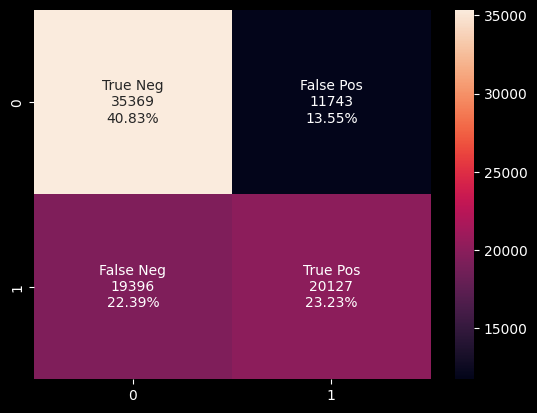

In [19]:
simple_wandb_run(0, names, classifiers, X_train, X_test, y_train, y_test, named_labels, project_name, training_sample = 20000)

## 4.2) Support Vector Machine

In [ ]:
# training sample must be considerably low since the SVM tends to take immense amounts of RAM and processing time that it can even crash Kaggle!

simple_wandb_run(1, names, classifiers, X_train, X_test, y_train, y_test, named_labels, project_name, training_sample = 20000)


Number of rows sampled: 20000


Data loaded in 0.12550711631774902 seconds..



## 4.3) Decision Tree

In [ ]:
simple_wandb_run(2, names, classifiers, X_train, X_test, y_train, y_test, named_labels, project_name, training_sample = 20000)

## 4.4) XGBoost

In [ ]:
simple_wandb_run(3, names, classifiers, X_train, X_test, y_train, y_test, named_labels, project_name, training_sample = 20000)

## 4.5) Passive Aggressive Classifier

In [ ]:
# Passive Aggressive Classifier does not provide ROC curves as you cant predict probabilities with it
simple_wandb_run(4, names, classifiers, X_train, X_test, y_train, y_test, named_labels, project_name, training_sample = 20000)

## 4.6) CNN-RNN Hybrid

## 4.7) BERT model